<h1><b>Méthode : EnKF-LSTM (EnKF)</b></h1>

In [2]:
import sys 

sys.path.insert(0, '..\\SOURCE')
sys.path.insert(0, '..\\data')
from EnKFLSTM_WoFost import EnKFLSTM_WoFost
from kalmanWoFost import KalmanWofostDA

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from dataloader import Dataloader

from pcse.base import ParameterProvider
from utils import *
import tensorflow as tf

## 1 - Paramètres de WOFOST

Dans cette partie, on va charger les paramètres qui serviront à modéliser le champ avec Wofost.
Dans cet exemple, on va essayer de simuler le champ de notre client


In [6]:
dataloader = Dataloader("..\\data")

# ===  1 - Crop Data ===
dataloader.printCropNames()
dataloader.printCropVarietes('potato')

cropd = dataloader.getCropData('potato', 'Innovator')
# Alternativement, vous pouvez charger un fichier
# cropd = dataloader.readCropData("POT701.CAB")



# === 2 - Paramètres du sol ===
# Chargé depuis un fichier
# 1. **EC1-Coarse**
# 2. **EC2-Medium**
# 3. **EC3-Medium Fine**
# 4. **EC4-Fine**
# 5. **EC5-Very Fine**
# 6. **EC6-Fine and Permeable (Peat)**
soild = dataloader.readSoilData("ec3.soil")

# === 3 - Paramètres du site ===
# Il s'agit des paramètres du site, indépendamment de l'espèce
#        - WAV       Initial amount of water in total soil profile [cm] <- OBLIGATOIRE
#        - IFUNRN    Indicates whether non-infiltrating fraction of rain is a function of storm size (1)
#                    or not (0). Default 0
#        - NOTINF    Maximum fraction of rain not-infiltrating into the soil [0-1], default 0.
#        - SSMAX     Maximum depth of water that can be stored on the soil surface [cm]
#        - SSI       Initial depth of water stored on the surface [cm]
#        - SMLIM     Initial maximum moisture content in initial rooting depth zone [0-1], default 0.4
sited = dataloader.getSiteData(WAV=10)


# === 4 - Agromanagement ===
agrod = dataloader.readAgromanagementData('osiris_rampe_cleaned.agro')

# === 5 - Météo ===
weatherd = dataloader.getWeatherData(lat=49.5652319502033, lon=2.4757816885380457)

# On rassemble tout
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

Voici la liste des espèces disponibles :
['barley', 'cassava', 'chickpea', 'cotton', 'cowpea', 'fababean', 'groundnut', 'maize', 'millet', 'mungbean', 'pigeonpea', 'potato', 'rapeseed', 'rice', 'sorghum', 'soybean', 'sugarbeet', 'sugarcane', 'sunflower', 'sweetpotato', 'tobacco', 'wheat', 'seed_onion']
Voici la liste des variétés disponibles pour : potato
['Potato_701', 'Potato_702', 'Potato_703', 'Potato_704', 'Innovator', 'Fontane', 'Markies', 'Premiere', 'Festien']


In [7]:
cropd = dataloader.getCropData('potato', 'Innovator')
print(cropd)

YAMLCropDataProvider - current active crop 'potato' with variety 'Innovator'
Available crop parameters:
 {'CO2EFFTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1.11, 2000.0, 1.11], 'CO2TRATB': [40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0.9, 2000.0, 0.9], 'CO2AMAXTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1.9, 2000.0, 1.9], 'TBASEM': 3.0, 'TEFFMX': 18.0, 'TSUMEM': 255, 'IDSL': 0, 'DLO': -99.0, 'DLC': -99.0, 'TSUM1': 187, 'TSUM2': 2100, 'DTSMTB': [0.0, 0.0, 2.0, 0.0, 13.0, 11.0, 30.0, 28.0], 'DVSI': 0.0, 'DVSEND': 2.0, 'VERNBASE': 14.0, 'VERNSAT': 70.0, 'VERNDVS': 0.3, 'VERNRTB': [-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17.0, 0.0, 20.0, 0.0], 'TDWI': 75.0, 'RGRLAI': 0.017, 'SLATB': [0.0, 0.0017, 1.0, 0.0024, 2.0, 0.0024], 'SPA': 0.0, 'SSATB': [0.0, 0.0, 2.0, 0.0], 'SPAN': 35.0, 'TBASE': 2.0, 'KDIFTB': [0.0, 1.0, 2.0, 1.0], 'EFFTB': [0.0, 0.49, 40.0, 0.49], 'AMAXTB': [0.0, 33.0, 2.0, 33.0], 'REFCO2L': 400, 'TMPFTB': [0.0, 0.01, 3.0, 0.01, 10.0, 0.75, 15.0, 1.0, 24.0, 1.0, 29.

## 2 - Simulation

On peut maintenant prédire avec WoFOST

In [8]:
wofost_noDA = getWofost_WaterLimited(parameters, weatherd, agrod)
wofost_noDA.run_till_terminate()
df_wofost_noDA = pd.DataFrame(wofost_noDA.get_output())
df_wofost_noDA = df_wofost_noDA.set_index("day")
df_wofost_noDA.tail()
#plotWofostDF(df_wofost_noDA)

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-10-02,1.983857,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.210778,22.853864
2022-10-03,1.989233,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.233504,23.990159
2022-10-04,1.993524,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.231734,23.901671
2022-10-05,1.998490,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.230315,23.830729
2022-10-06,2.000000,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.229977,23.813845


# 3 - Observations

On va réaliser des observations pour améliorer notre simulation : c'est la data assimilation.

Dans cette partie, on va utiliser les observations du client

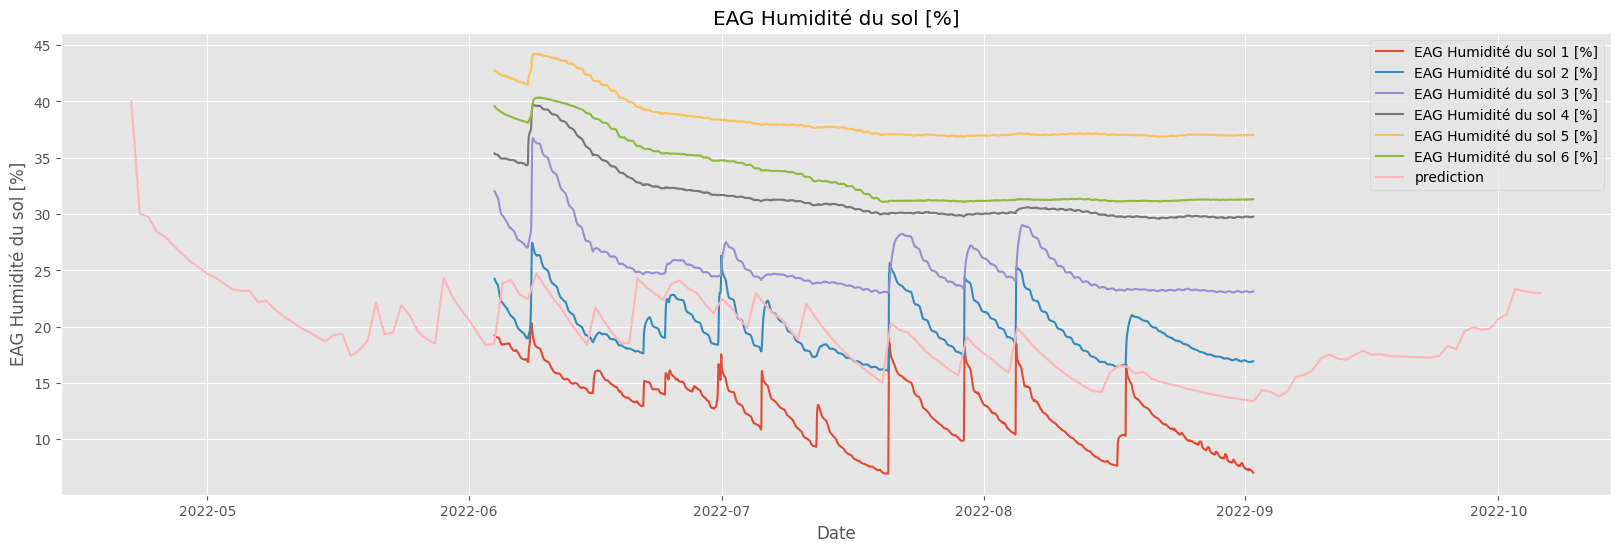

In [9]:


df_obs = dataloader.readOsirisData('Sonde Rampe 1.csv')
df_obs = df_obs[df_obs['Date/heure'] < pd.Timestamp("2022-09-02")]
df_obs = df_obs[df_obs['Date/heure'] > pd.Timestamp("2022-06-04")]

plt.figure(figsize=(20, 6))

for i in range(1, 7):
    column_name = f'EAG Humidité du sol {i} [%]'
    plt.plot(df_obs['Date/heure'],df_obs[column_name], label=column_name)
    
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM']*100, label='prediction')
plt.title("EAG Humidité du sol [%]")
plt.xlabel('Date')
plt.legend()
plt.ylabel("EAG Humidité du sol [%]")
plt.grid(True)
plt.show()

On ne garde que la courbe EAG 2%

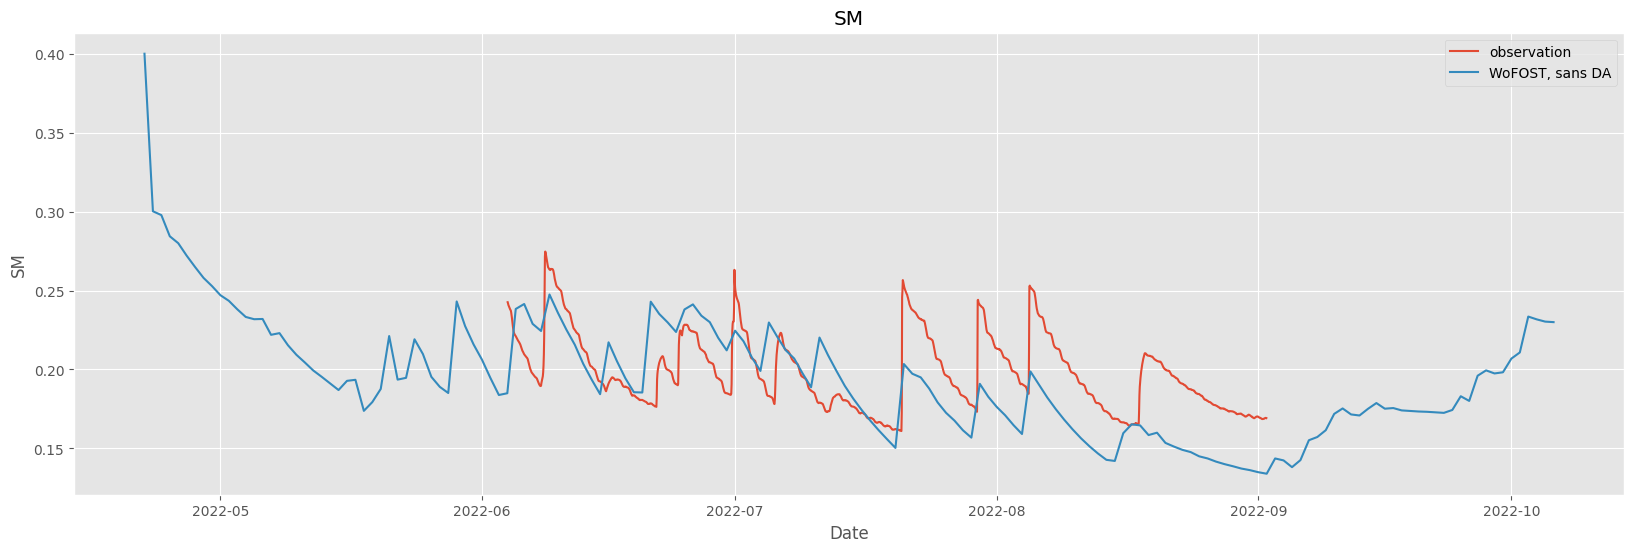

In [11]:
plt.figure(figsize=(20, 6))

plt.plot(df_obs['Date/heure'], df_obs['SM'], label = 'observation')
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM'], label='WoFOST, sans DA')
plt.title("SM")
plt.xlabel('Date')
plt.legend()
plt.ylabel("SM")
plt.grid(True)
plt.show()

Pour mesurer l'effet de la fréquence des mesures, on va échantilloner les données à notre disposition

In [12]:
NB_DAYS_DELTA = 4
dates_of_observation, observed_sm = dataloader.getOsirisSM(filename = 'Sonde Rampe 1.csv', timedelta = pd.Timedelta(NB_DAYS_DELTA, "d"), error = 0.0, begin = pd.Timestamp("2022-06-04"), end = pd.Timestamp("2022-09-02"))

observed_sm = np.array(observed_sm)
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value

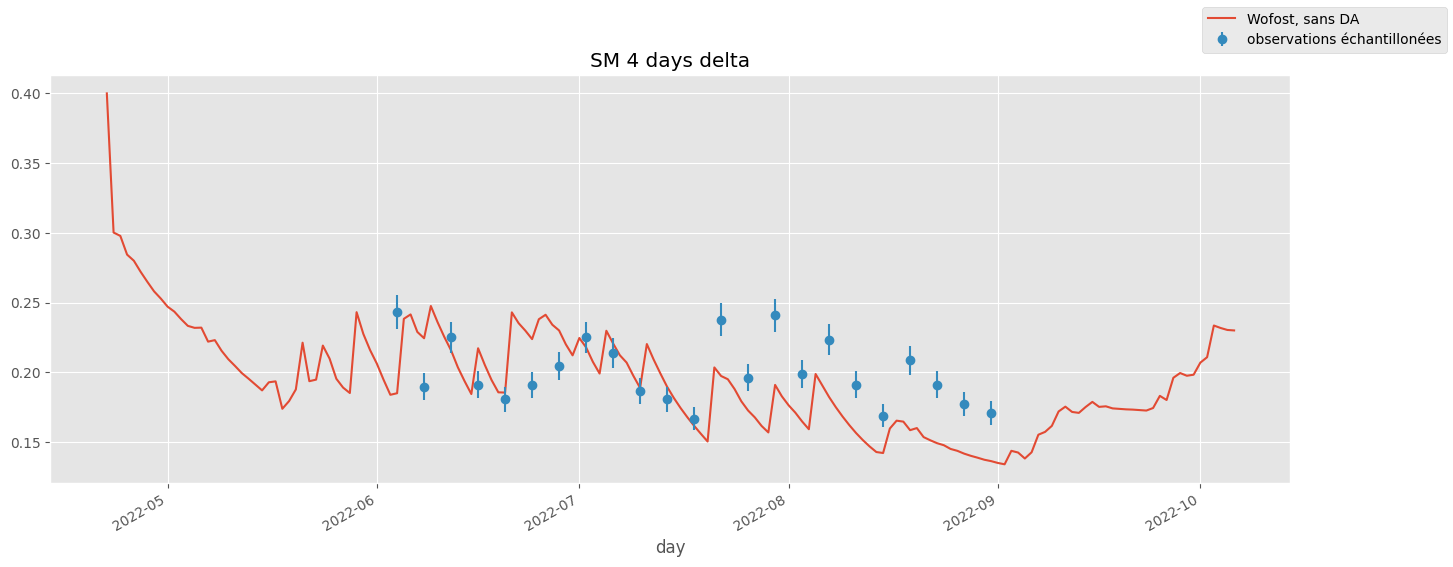

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
df_wofost_noDA["SM"].plot(ax=axes, label="Wofost, sans DA")
axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o", label='observations échantillonées')
axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
fig.legend()

On doit maintenant tout rassembler :

In [14]:
observations_for_DA = [(d, {"SM": (sm, errsm)}) for d, sm, errsm in zip(dates_of_observation, observed_sm, std_sm)]

## 4 - EnKF-LSTM

On peut maintenant utiliser l'EnKF-LSTM

Il faut d'abord spécifier les paramètres sur lesquels on a un doute.

In [19]:
ensemble_size = 50
np.random.seed(10000)

print("TDWI", parameters['TDWI'])
print("WAV", parameters["WAV"])
print("SPAN", parameters["SPAN"])
print("SMFCF", parameters["SMFCF"])

TDWI 75.0
WAV 10.0
SPAN 35.0
SMFCF 0.3



On créé ensuite une zone de recherche autour des paramètres que l'on cherche à assimiler.

In [20]:
ensemble_size = 50

override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.maximum(0.5, np.random.normal(parameters['TDWI'], 10, (ensemble_size)))
override_parameters["WAV"] = np.maximum(0.5, np.random.normal(parameters['WAV'], 1.0, (ensemble_size)))
# parameters
override_parameters["SPAN"] = np.maximum(0.5, np.random.normal(parameters['SPAN'], 4 ,(ensemble_size)))
override_parameters["SMFCF"] = np.maximum(0.05, np.random.normal(parameters['SMFCF'], 0.02 ,(ensemble_size)))

kwf = KalmanWofostDA(parameters=parameters, weather=weatherd, agromanagement=agrod, ensemble_size=ensemble_size, override_parameters=override_parameters)
kwf.batchAssimilate(observations_for_DA)
kwf.completeSim()
df_enkf_DA = kwf.getResultsWithDA()
df_enkf_NODA = kwf.getResultsNoDA()


[KalmanWoFoStDA] Assimilating data for {'SM': (0.24350000000000002, 0.012175000000000002)} on day 2022-06-04 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.18969999999999998, 0.009485)} on day 2022-06-08 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.225, 0.011250000000000001)} on day 2022-06-12 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1911, 0.009555000000000001)} on day 2022-06-16 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1807, 0.009035)} on day 2022-06-20 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1907, 0.009535000000000002)} on day 2022-06-24 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2045, 0.010225)} on day 2022-06-28 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.22510000000000002, 0.011255000000000001)} on day 2022-07-02 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2139, 0.010695000000000001)} on day 2022-07-06 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM'

On génère N données en utilisant l'EnKF

In [21]:
X_LSTM = []
Y_LSTM = []

iEssai = 0
while iEssai < 30:
    print("=== Generation", iEssai,"===")
    try:
        ensemble_size = 50

        override_parameters = {}
        # Initial conditions
        override_parameters["TDWI"] = np.maximum(0.5, np.random.normal(parameters['TDWI'], 10, (ensemble_size)))
        override_parameters["WAV"] = np.maximum(0.5, np.random.normal(parameters['WAV'], 1.0, (ensemble_size)))
        # parameters
        override_parameters["SPAN"] = np.maximum(0.5, np.random.normal(parameters['SPAN'], 4 ,(ensemble_size)))
        override_parameters["SMFCF"] = np.maximum(0.05, np.random.normal(parameters['SMFCF'], 0.05 ,(ensemble_size)))

        kwf = KalmanWofostDA(parameters=parameters, weather=weatherd, agromanagement=agrod, ensemble_size=ensemble_size, override_parameters=override_parameters)
        kwf.batchAssimilate(observations_for_DA)
        df_enkf_DA = kwf.getResultsWithDA()
        df_enkf_NODA = kwf.getResultsNoDA()

        X_LSTM.append(kwf.trainX)
        Y_LSTM.append(kwf.trainY)
        iEssai += 1
    except:
        print("Error")
        continue

=== Generation 0 ===
[KalmanWoFoStDA] Assimilating data for {'SM': (0.24350000000000002, 0.012175000000000002)} on day 2022-06-04 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.18969999999999998, 0.009485)} on day 2022-06-08 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.225, 0.011250000000000001)} on day 2022-06-12 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1911, 0.009555000000000001)} on day 2022-06-16 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1807, 0.009035)} on day 2022-06-20 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1907, 0.009535000000000002)} on day 2022-06-24 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2045, 0.010225)} on day 2022-06-28 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.22510000000000002, 0.011255000000000001)} on day 2022-07-02 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2139, 0.010695000000000001)} on day 2022-07-06 00:00:00 
[KalmanWoFoStDA] Assimi

On entraîne les LSTMs à chaque instant où une observation a lieu

In [22]:


models = []

for iObs in range(len(X_LSTM[0])): # TIME of the LSTM model. From all mesures <= TIME, it will predict TIME+1

    print("\n===", iObs,"/", len(X_LSTM[0]), "===")

    # Define LSTM model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(X_LSTM[0][iObs].shape[1],X_LSTM[0][iObs].shape[0])))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(len(Y_LSTM[0][iObs])))
    #model.summary()
    # Compile model
    model.compile(loss='mse', optimizer='adam')

    # Train model
    X_train = []
    y_train = []
    for iEl in range(len(X_LSTM)):
        X_train.append(np.transpose(X_LSTM[iEl][iObs]))
        y_train.append(Y_LSTM[iEl][iObs])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    print(X_train.shape, y_train.shape)
    
    model.fit(X_train, y_train, epochs=50, batch_size=8)

    models.append(model)



=== 0 / 23 ===
(30, 44, 51) (30, 50)
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0667
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0338
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0189 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0098 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9099e-04
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3815e-04
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4671e-04
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.1977e-04
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3605e-04
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3128e-04
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7617e-04
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━

On peut finalement utiliser les LSTMs pour réaliser la data assimilation

In [23]:

ensemble_size = 50

override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.maximum(0.5, np.random.normal(parameters['TDWI'], 10, (ensemble_size)))
override_parameters["WAV"] = np.maximum(0.5, np.random.normal(parameters['WAV'], 1.0, (ensemble_size)))
# parameters
override_parameters["SPAN"] = np.maximum(0.5, np.random.normal(parameters['SPAN'], 4 ,(ensemble_size)))
override_parameters["SMFCF"] = np.maximum(0.05, np.random.normal(parameters['SMFCF'], 0.02 ,(ensemble_size)))

kwf = EnKFLSTM_WoFost(parameters=parameters, weather=weatherd, agromanagement=agrod, ensemble_size=ensemble_size, override_parameters=override_parameters)
kwf.batchAssimilate(observations_for_DA, models)
kwf.completeSim()

df_enkf_lstm_DA = kwf.getResultsWithDA()
df_enkf_lstm_NODA = kwf.getResultsNoDA()


[EnKFLSTM_WoFost] Assimilating data for {'SM': (0.24350000000000002, 0.012175000000000002)} on day 2022-06-04 00:00:00 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
[EnKFLSTM_WoFost] Assimilating data for {'SM': (0.18969999999999998, 0.009485)} on day 2022-06-08 00:00:00 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
[EnKFLSTM_WoFost] Assimilating data for {'SM': (0.225, 0.011250000000000001)} on day 2022-06-12 00:00:00 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
[EnKFLSTM_WoFost] Assimilating data for {'SM': (0.1911, 0.009555000000000001)} on day 2022-06-16 00:00:00 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
[EnKFLSTM_WoFost] Assimilating data for {'SM': (0.1807, 0.009035)} on day 2022-06-20 00:00:00 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
[EnKFLSTM_WoFost] Assimilating data for {'SM': (0.1907, 0.009535000000000002)} on day 2022-06-24 00:00:00 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
[EnKFLSTM_WoFost] Assimilating data for {'SM': (0.2045, 0.010225)} on day 2022-06-28 00:00:00 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

On peut comparer les résultats avec l'EnKF :

In [24]:
kwf = KalmanWofostDA(parameters=parameters, weather=weatherd, agromanagement=agrod, ensemble_size=ensemble_size, override_parameters=override_parameters)
kwf.batchAssimilate(observations_for_DA)
kwf.completeSim()
df_enkf_DA = kwf.getResultsWithDA()
df_enkf_NODA = kwf.getResultsNoDA()

[KalmanWoFoStDA] Assimilating data for {'SM': (0.24350000000000002, 0.012175000000000002)} on day 2022-06-04 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.18969999999999998, 0.009485)} on day 2022-06-08 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.225, 0.011250000000000001)} on day 2022-06-12 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1911, 0.009555000000000001)} on day 2022-06-16 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1807, 0.009035)} on day 2022-06-20 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1907, 0.009535000000000002)} on day 2022-06-24 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2045, 0.010225)} on day 2022-06-28 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.22510000000000002, 0.011255000000000001)} on day 2022-07-02 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2139, 0.010695000000000001)} on day 2022-07-06 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM'

Résultats

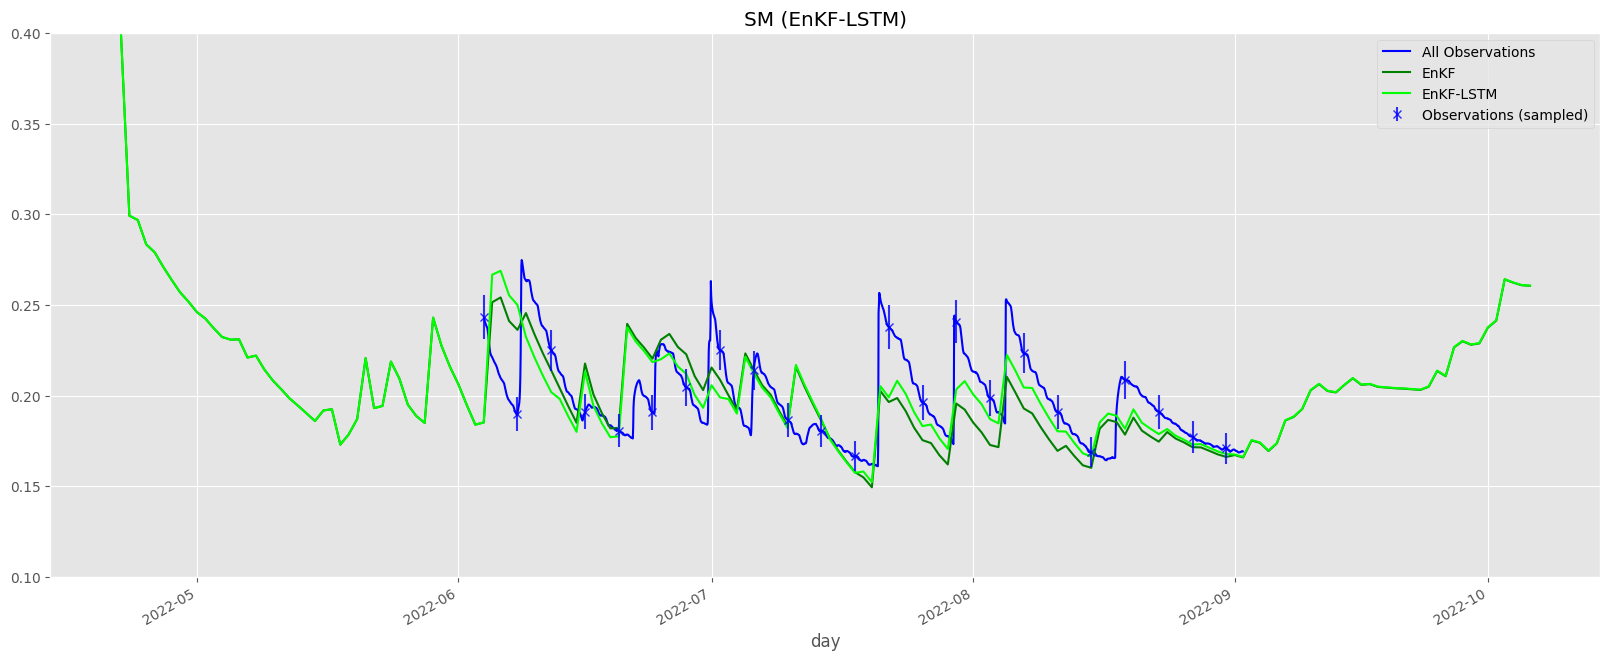

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=True)

axes.plot(df_obs['Date/heure'], df_obs["SM"], label="All Observations", color='b')

#axes.plot(df_enkf_DA.index.to_numpy()[:-1], X_LSTM[14,:,50], label="test", color="black")
df_enkf_DA['SM'].plot(ax=axes, label="EnKF", color='g')
#df_enkf_NODA['SM'].plot(ax=axes, label="NoDA", color='r')
df_enkf_lstm_DA['SM'].plot(ax=axes, label="EnKF-LSTM", color='lime')

axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="x", alpha=0.8, color='b', label='Observations (sampled)')
axes.set_title("SM (EnKF-LSTM)")
fig.autofmt_xdate()
axes.set_ylim([0.1, 0.4])

axes.legend()

Calculons maintenant le RMSE :

In [27]:
df_obs_undersample = df_obs[df_obs['Date/heure'].dt.hour == 0]
minDay = max((df_obs_undersample['Date/heure'].min()), df_enkf_DA.index.min())
maxDay = min(df_obs_undersample['Date/heure'].max(), df_enkf_DA.index.max())

df_obs_undersample.index = df_obs_undersample['Date/heure']

SM_obs = df_obs_undersample.loc[(df_obs_undersample.index >= minDay) & (df_obs_undersample.index <= maxDay), 'SM'].to_numpy()
SM_ENKF = df_enkf_DA.loc[(df_enkf_DA.index >= minDay) & (df_enkf_DA.index <= maxDay), 'SM'].to_numpy()
SM_noDA = df_enkf_NODA.loc[minDay:maxDay, 'SM'].to_numpy()
SM_ENKF_LSTM = df_enkf_lstm_DA.loc[(df_enkf_lstm_DA.index >= minDay) & (df_enkf_lstm_DA.index <= maxDay), 'SM'].to_numpy()

print("===RMSE===")
print("NoDA :",np.sqrt(np.mean((SM_obs-SM_noDA)**2)))
print("ENKF :",np.sqrt(np.mean((SM_obs-SM_ENKF)**2)))
print("ENKF_LSTM :",np.sqrt(np.mean((SM_obs-SM_ENKF_LSTM)**2)))

===RMSE===
NoDA : 0.029770553084084113
ENKF : 0.02261610615991487
ENKF_LSTM : 0.02178961478938858


In [28]:
rsme = {i:np.sqrt(np.mean((SM_obs[1:i]-SM_ENKF[1:i])**2)) for i in range(len(SM_ENKF))}
result = list(rsme.values())/np.mean(SM_obs)
print("EnKF RMSE 4 days:", result[-1])

EnKF RMSE 4 days: 0.11401445932308257


c:\Users\Erwin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Erwin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [29]:
rsme = {i:np.sqrt(np.mean((SM_obs[1:i]-SM_ENKF_LSTM[1:i])**2)) for i in range(len(SM_ENKF_LSTM))}
result = list(rsme.values())/np.mean(SM_obs)
print("EnKF_LSTM RMSE 4 days:", result[-1])

EnKF_LSTM RMSE 4 days: 0.1082186695754254


Témoin: 0.1499207401310168


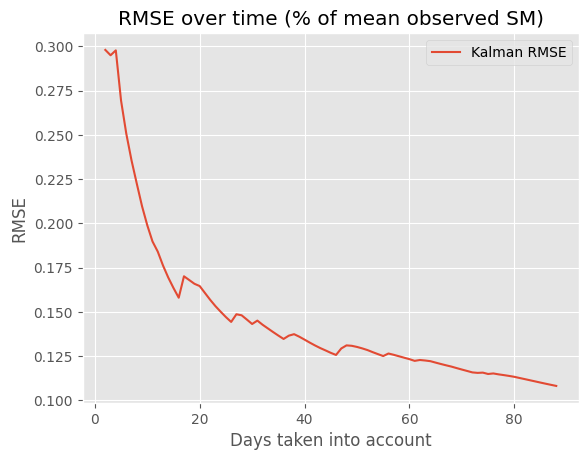

In [30]:

plt.plot(list(rsme.keys()),list(rsme.values())/np.mean(SM_obs), label="Kalman RMSE")
print("Témoin: {}".format(np.sqrt(np.mean((SM_obs-SM_noDA)**2))/np.mean(SM_obs)))
plt.title("RMSE over time (% of mean observed SM)")
plt.xlabel("Days taken into account")
plt.ylabel("RMSE")
plt.legend()

Témoin: 0.1499207401310168


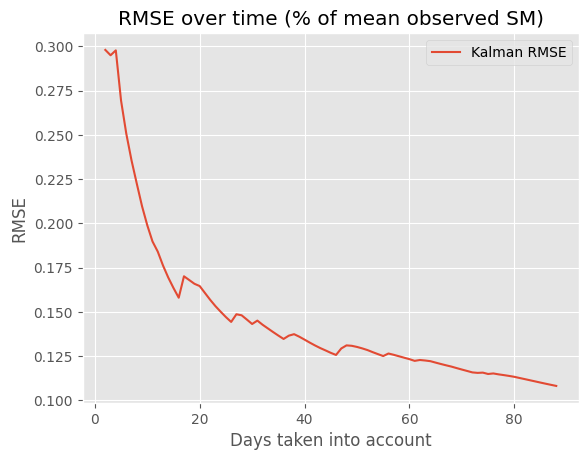

In [31]:
rsme = {i:np.sqrt(np.mean((SM_obs[1:i]-SM_ENKF_LSTM[1:i])**2)) for i in range(len(SM_ENKF_LSTM))}
plt.plot(list(rsme.keys()),list(rsme.values())/np.mean(SM_obs), label="Kalman RMSE")
print("Témoin: {}".format(np.sqrt(np.mean((SM_obs-SM_noDA)**2))/np.mean(SM_obs)))
plt.title("RMSE over time (% of mean observed SM)")
plt.xlabel("Days taken into account")
plt.ylabel("RMSE")
plt.legend()